## import libraries

In [ ]:
import sys
!pip uninstall torch torchvision torchaudio

In [44]:
import torch
torch.cuda.is_available()

True

In [45]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np 
import csv
import os
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torch import nn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Load data

In [46]:
import urllib.request
import os
import zipfile
if not os.path.exists(os.getcwd()+"/ipeo_data"):
    with zipfile.ZipFile(os.getcwd()+"/ipeo_data.zip", 'r') as zip_ref:
        zip_ref.extractall()


In [47]:
train_csv = open(os.getcwd()+"/ipeo_data/splits/train.csv")
train_csv  = csv.reader(train_csv)
test_csv = open(os.getcwd()+"/ipeo_data/splits/test.csv")
test_csv  = csv.reader(test_csv)
val_csv = open(os.getcwd()+"/ipeo_data/splits/val.csv")
val_csv  = csv.reader(val_csv)
### CAREFUL need to remove the "25595_11025_label" from the validation dataset. Empty image ?
### remove direcly in the val excel fil (row = 629)

## Set up the data

In [404]:
from torch.utils.data import Dataset

from PIL import Image

import os
import glob

"""CLASS rocks (1), scree (2), sparse rocks (3), water (4), glacier and permanent snow (5), forest(6), sparse forest(7),
grasslands and others (8)."""

class Alpine(Dataset):

    # mapping between label class names and indices
    LABEL_CLASSES = {
      'rocks': 		  7,
      'scree': 			    6,
      'sparse_rocks': 	  5,
      'water': 				      3,
      'glacier_and_permanent_snow': 			    4,
      'forest': 			    1,
      'sparse_forest':   2,
      'grasslands_and_others': 				    0,
      
    }

    def __init__(self, transforms=None,transforms_under_rep_class = None, split='train',frac=1.0):
        self.transforms = transforms
        self.transforms_under_rep_class = transforms_under_rep_class
        #only for label_image
        transforms_label = T.Compose([
        T.ToTensor()
        ])
        
        self.transforms_label = transforms_label
        # prepare data
        self.data = []                                  # list of tuples of (image path, label class)
        # get images with correct index according to dataset split
        if split=='train':
            data_csv = open(os.getcwd()+"/ipeo_data/splits/train.csv")
            data_csv  = list(csv.reader(data_csv))
            length = int(frac*len(data_csv))
        if split=='test':
            data_csv = open(os.getcwd()+"/ipeo_data/splits/test.csv")
            data_csv  = list(csv.reader(data_csv))
            length = int(frac*len(data_csv))
        if split=='val':
            data_csv = open(os.getcwd()+"/ipeo_data/splits/val.csv")
            data_csv  = list(csv.reader(data_csv))
            length = int(frac*len(data_csv))
        
        i=0

        for row in data_csv :
            if i<length:
                img_name = os.getcwd()+"/ipeo_data/rgb/"+row[0]+"_rgb.tif"
                img_label_name = os.getcwd()+"/ipeo_data/alpine_label/"+row[0]+"_label.tif"   
                i+=1
                
                if self.transforms_under_rep_class is not None: # We get only under rep classes
                    img = np.array(Image.open(img_name))
                    img_label = np.array(Image.open(img_label_name))   
           
                    one = len(np.where(img_label == 1)[0])
                    two = len(np.where(img_label == 2)[0])
                    five = len(np.where(img_label == 5)[0])
                    
                    if one/(200*200)>0.3 or two/(200*200)>0.3 or five/(200*200)>0.3:
                        self.data.append((
                            img_name,
                            img_label_name          # get index for label class
                        ))

                else: # We get all 
                    self.data.append((
                        img_name,
                        img_label_name          # get index for label class
                    ))
        print(len(self.data))
        

            
    def __len__(self):
        return len(self.data)


    def __getitem__(self, x):
        img_name, img_label_name = self.data[x]
    
        img = Image.open(img_name)
        img_label = Image.open(img_label_name)
        
        
        if self.transforms is not None:
            if self.transforms_under_rep_class is not None: #Only for increase the under represent dataset
                img = self.transforms_under_rep_class(img)
                img = normalize(img)
                img_label = self.transforms_under_rep_class(img_label)

                
            else:
                img = self.transforms(img)
                img_label = self.transforms_label(img_label)
                
        return img,img_label


## Transforms train + val

In [405]:

# mean and standard deviation of the dataset 
mean=torch.tensor([0.4572, 0.5079, 0.4388])
std=torch.tensor([0.2366, 0.2141, 0.1992])
# normalize image [0-1] (or 0-255) to zero-mean unit standard deviation
normalize = T.Normalize(mean, std)
# we invert normalization for plotting later
std_inv = 1 / (std + 1e-7)
unnormalize = T.Normalize(-mean * std_inv, std_inv)

transforms_train = T.Compose([
  #TODO: add your own transforms here

  T.Resize((200, 200)),
  T.ToTensor(),
  normalize
])

# we do not augment the validation dataset (aside from resizing and tensor casting)
transforms_val = T.Compose([
  T.Resize((200, 200)),
  T.ToTensor(),
  normalize
])



In [406]:
# initialize the dataset (call the constructor __init__)

dataset_augmentation =  Alpine(transforms=transforms_train,transforms_under_rep_class=transform_under_rep_class, split="train", frac=frac)
#dataset = Alpine(transforms=transforms_train,transforms_under_rep_class=None, split="train", frac=frac)

print(f"dataset_augmentation of length {len(dataset_augmentation)}")
# plot individual samples
from ipywidgets import interact
@interact(idx=range(1000))
def plot_sample(idx=0):
    img, img_label = dataset[idx]
    img = unnormalize(img).permute(1,2,0)
    img_label = img_label.permute(1,2,0)
    plt.figure(figsize=(15, 6))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(img_label)




1692
dataset_augmentation of length 1692


interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

## Test ( Image input 400 sur 400 / label 200 sur 200 --> need to resize the input)

In [228]:
test_dataset = Alpine(transforms=transforms_train, split='test')

3679


In [400]:
len(np.where(test_dataset[0][1][0] == 5)[0])

23312

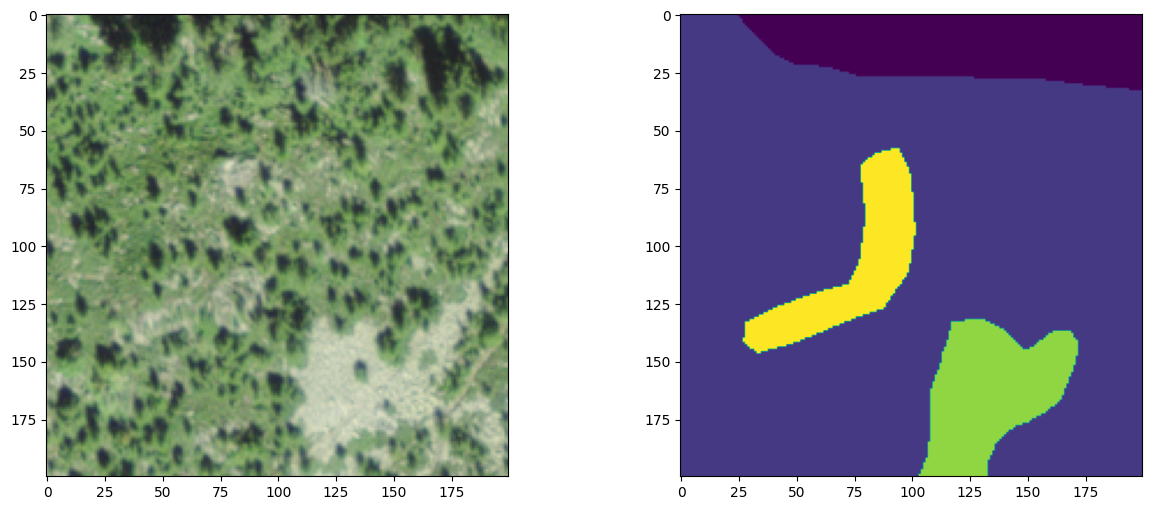

In [244]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.imshow(unnormalize(test_dataset[94][0]).permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow((test_dataset[94][1]).permute(1,2,0))

## Deal with imbalanced data

### weighted class

In [414]:
#In the train+val data:
"""
Number of pixels of grasslands and others : 72519725
Number of pixels of forest : 19336033
Number of pixels of sparse forest : 18342686
Number of pixels of water : 5936946
Number of pixels of glacier and permanent snow : 10797402
Number of pixels of sparse rocks : 16857098
Number of pixels of scree : 78876458
Number of pixels of rocks : 71613652
"""
class_counts = np.array([72519725,19336033,18342686,5936946,10797402,16857098,78876458,71613652])
# Calculate class frequencies
frequency = class_counts / sum(class_counts)

# Calculate class weights
class_weights = 1 / frequency
class_weights[1]+=10
# Convert class weights to tensor
class_weights = torch.tensor(class_weights, dtype=torch.float,device="cuda")

In [415]:
class_weights,frequency

(tensor([ 4.0579, 25.2193, 16.0435, 49.5676, 27.2547, 17.4573,  3.7309,  4.1093],
        device='cuda:0'),
 array([0.24643104, 0.06570624, 0.06233073, 0.02017448, 0.03669091,
        0.05728251, 0.268032  , 0.24335209]))

### data augmentation under-representated class

In [371]:
# Define the data augmentation transformations for the underrepresented class
transforms_under_rep_class = T.Compose([
    T.Resize((200, 200)),
    T.ToTensor(),
    T.RandomHorizontalFlip(p=1),
    T.RandomVerticalFlip(p=1),
])



## Model  UNet + https://github.com/milesial/Pytorch-UNet

In [50]:
import torch.nn.functional as F
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [51]:
""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        self.down4 = Down(128, 256)
        self.down5 = Down(256, 512)       
        factor = 2 if bilinear else 1
        self.down6 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.up5 = Up(64, 32, bilinear)
        self.up6 = Up(32, 16, bilinear)
        
        self.outc = OutConv(16, n_classes) #initial size ! (MLP here )
        ## Note : the last step == fully connected NN (MLP) || could be repplace by a Random forest methods ! (try)

    def forward(self, x,RF=False):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        x7 = self.down6(x6)
        
        x = self.up1(x7, x6)
        x = self.up2(x, x5)
        x = self.up3(x, x4)
        x = self.up4(x, x3)
        x = self.up5(x, x2)
        x = self.up6(x, x1)
        
        if not RF :
            logits = self.outc(x)
            return logits
        else :
            return x

# Deep UNet

In [17]:
import torch.nn.functional as F
"""class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
"""

class Down0(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self):
        super().__init__()
        self.Down = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(3,64,kernel_size=3,padding=1,bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=3,padding=1,bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,32,kernel_size=2,padding=0,bias=False),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.Down(x)
    
class Downn(nn.Module):
    def __init__(self):
        super().__init__()
        self.Down = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(32,64,kernel_size=3,padding=1,bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,32,kernel_size=2,padding=1,bias=False),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.Down(x)   

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self,bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [18]:
class DeepUNet(nn.Module):
    def __init__(self,n_channels,n_classes,bilinear=False):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        #self.inc = DoubleConv(n_channels,32)
        self.down1 = Down0()
        self.downn = Downn()

# RESUNet implementation

In [19]:
class batchnorm_relu(nn.Module):
    def __init__(self, in_c):
        super().__init__()

        self.bn = nn.BatchNorm2d(in_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.bn(inputs)
        x = self.relu(x)
        return x

class residual_block(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()

        """ Convolutional layer """
        self.b1 = batchnorm_relu(in_c)
        self.c1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride)
        self.b2 = batchnorm_relu(out_c)
        self.c2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, stride=1)

        """ Shortcut Connection (Identity Mapping) """
        self.s = nn.Conv2d(in_c, out_c, kernel_size=1, padding=0, stride=stride)

    def forward(self, inputs):
        x = self.b1(inputs)
        x = self.c1(x)
        x = self.b2(x)
        x = self.c2(x)
        s = self.s(inputs)

        skip = x + s
        return skip

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.r = residual_block(in_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.upsample(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.r(x)
        return x

class resunet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        """ Encoder 1 """
        self.c11 = nn.Conv2d(n_channels, 64, kernel_size=3, padding=1)
        self.br1 = batchnorm_relu(64)
        self.c12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.c13 = nn.Conv2d(3, 64, kernel_size=1, padding=0)

        """ Encoder 2 and 3 """
        self.r2 = residual_block(64, 128, stride=2)
        self.r3 = residual_block(128, 256, stride=2)

        """ Bridge """
        self.r4 = residual_block(256, 512, stride=2)

        """ Decoder """
        self.d1 = decoder_block(512, 256)
        self.d2 = decoder_block(256, 128)
        self.d3 = decoder_block(128, 64)

        """ Output """
        self.output = nn.Conv2d(64, n_classes, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid(axis=1)

    def forward(self, inputs):
        """ Encoder 1 """
        x = self.c11(inputs)
        x = self.br1(x)
        x = self.c12(x)
        s = self.c13(inputs)
        skip1 = x + s

        """ Encoder 2 and 3 """
        skip2 = self.r2(skip1)
        skip3 = self.r3(skip2)

        """ Bridge """
        b = self.r4(skip3)

        """ Decoder """
        d1 = self.d1(b, skip3)
        d2 = self.d2(d1, skip2)
        d3 = self.d3(d2, skip1)

        """ output """
        output = self.output(d3)
        output = self.sigmoid(output)

        return output



## Random forest

#### Add a RF classsifier inside the UNet model

## Getloader

In [375]:
def get_dataloaders(split,data_augmentation,frac):   
    data_dataset = Alpine(transforms=transforms_train,transforms_under_rep_class=None, split=split, frac=frac)
    
    if data_augmentation and split!="test": #Dataset increase for under rep classes
        dataset_augmentation =  Alpine(transforms=transforms_train,transforms_under_rep_class=transform_under_rep_class, split=split, frac=frac)
        data_dataset = data_dataset + dataset_augmentation
    print(len(data_dataset))
    shuffle = True
    if split == "test":
        shuffle = False
    # data loader
    data_loader = DataLoader(data_dataset, 
                              batch_size  = 4, 
                              shuffle     = shuffle, 
                              num_workers = 0,
                              pin_memory  = False)
    return data_dataset, data_loader

In [407]:

def train_epoch(class_weights,model, optimizer, scheduler, criterion, train_loader, epoch, device,RF,random_forest):
    ### SOLUTION
    model.train()
    loss_history = []
    accuracy_history = []
    lr_history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor) #avoid an error idk why?
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, RF) #if RF --> output == features ! 
        
        #print(output.shape) #[batch,class,200,200]
        #print(target.shape)#[batch,1,200,200]
        #Newsize for criterion
        output = output.permute(1,0,2,3).flatten(1).permute(1,0) #[batch*200*200,class]
        target = target.flatten() #[batch*200*200]  
        loss = criterion(output, target,weight =class_weights)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if RF :
            features = output.cpu().detach().numpy()
            target = target.cpu().detach().numpy()
            random_forest.fit(features, target)
            predictions = random_forest.predict(features)
            accuracy_float = accuracy_score(target, predictions)
            loss_float = loss.item()
        
        else :     
            predictions = output.argmax(1).cpu().detach().numpy()
            ground_truth = target.cpu().detach().numpy()
            #correct = pred.eq(target.view_as(pred)).sum().item()
            #ccuracy_float = correct / len(output[0])

            accuracy_float = (predictions == ground_truth).mean()
            loss_float = loss.item()

        loss_history.append(loss_float)
        accuracy_history.append(accuracy_float)
        lr_history.append(scheduler.get_last_lr()[0])
        if batch_idx % (len(train_loader.dataset) // len(data) // 10) == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx:03d} "
                f"batch_loss={loss_float:0.2e} "
                f"batch_acc={accuracy_float:0.3f} "
                f"lr={scheduler.get_last_lr()[0]:0.3e} "
            )

    return loss_history, accuracy_history, lr_history


@torch.no_grad()
def validate(class_weights,model, device, val_loader, criterion,RF,random_forest):
    model.eval()  # Important: eval mode (affects dropout, batch norm etc)
    test_loss = 0
    accuracy_float = 0 
    for data, target in val_loader:
        target = target.type(torch.LongTensor) #avoid an error idk why?
        data, target = data.to(device), target.to(device)
        output = model(data,RF=False)
        output = model(data, RF)

        output = output.permute(1,0,2,3).flatten(1).permute(1,0) #[batch*200*200,class]
        target = target.flatten() #[batch*200*200]
        
        test_loss += criterion(output, target,weight =class_weights)
        
        
        if RF :
            features = output.cpu().detach().numpy()
            ground_truth = target.cpu().detach().numpy()
            predictions = random_forest.predict(features)
            accuracy_float += accuracy_score(ground_truth, predictions)
            
        
        else :     
            predictions = output.argmax(1).cpu().detach().numpy()
            ground_truth = target.cpu().detach().numpy()
            accuracy_float += (predictions == ground_truth).mean()
            
    

    test_loss /= len(val_loader)

    print(
        "Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            accuracy_float,
            len(val_loader),
            100.0 * accuracy_float / len(val_loader),
        )
    )
    return test_loss, accuracy_float / len(val_loader)


def run_training(
    data_augmentation,
    class_weights,
    model_factory,
    num_epochs,
    optimizer_kwargs,
    device="cuda",
    RF=False,
    frac=1.0,
):
    # ===== Data Loading =====
    train_loader = get_dataloaders("train",data_augmentation,frac=frac)[1]
    val_loader = get_dataloaders("val",data_augmentation,frac=frac)[1]

    # ===== Model, Optimizer and Criterion =====
    model = UNet(3,8)
    model = model.to(device)
    if RF :
        random_forest = RandomForestClassifier(n_estimators=10)
    else:
        random_forest = None
    optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
    criterion = torch.nn.functional.cross_entropy
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )

    # ===== Train Model =====
    lr_history = []
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    
    print("le training commence!")
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc, lrs = train_epoch(
            class_weights,model, optimizer, scheduler, criterion, train_loader, epoch, device,RF,random_forest
        )
        train_loss_history.extend(train_loss)
        train_acc_history.extend(train_acc)
        lr_history.extend(lrs)

        val_loss, val_acc = validate(class_weights,model, device, val_loader, criterion,RF,random_forest)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
    
    #test part
    if RF : 
        return  (sum(train_acc) / len(train_acc), val_acc, model,random_forest)
    else :
        return (sum(train_acc) / len(train_acc), val_acc, model, None)





In [408]:
#from RF_from_CNN import RF_CNN

torch.cuda.empty_cache()
data_augmentation = True 
model_factory = UNet
num_epochs = 10
frac=1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

optimizer_kwargs = dict(
    lr=1e-3,
    weight_decay=1e-2,
)

train_acc,val_acc,model,random_forest = run_training(
    data_augmentation,
    class_weights=class_weights,
    model_factory=UNet,
    num_epochs=num_epochs,
    optimizer_kwargs=optimizer_kwargs,
    device=device,
    RF=False,
    frac=frac
)

cuda
7357
1692
9049
1225
102
1327
le training commence!
Train Epoch: 1-000 batch_loss=2.03e+00 batch_acc=0.134 lr=1.000e-03 
Train Epoch: 1-226 batch_loss=1.50e+00 batch_acc=0.456 lr=9.998e-04 
Train Epoch: 1-452 batch_loss=1.37e+00 batch_acc=0.534 lr=9.990e-04 
Train Epoch: 1-678 batch_loss=1.42e+00 batch_acc=0.458 lr=9.978e-04 
Train Epoch: 1-904 batch_loss=1.29e+00 batch_acc=0.287 lr=9.961e-04 
Train Epoch: 1-1130 batch_loss=1.60e+00 batch_acc=0.325 lr=9.938e-04 
Train Epoch: 1-1356 batch_loss=1.02e+00 batch_acc=0.583 lr=9.911e-04 
Train Epoch: 1-1582 batch_loss=1.00e+00 batch_acc=0.538 lr=9.880e-04 
Train Epoch: 1-1808 batch_loss=1.45e+00 batch_acc=0.327 lr=9.843e-04 
Train Epoch: 1-2034 batch_loss=1.54e+00 batch_acc=0.376 lr=9.802e-04 
Train Epoch: 1-2260 batch_loss=1.19e+00 batch_acc=0.459 lr=9.756e-04 
Val set: Average loss: 1.3359, Accuracy: 114.61033750000007/332 (35%)
Train Epoch: 2-000 batch_loss=8.51e-01 batch_acc=0.703 lr=9.755e-04 
Train Epoch: 2-226 batch_loss=1.50e+00 b

Train Epoch: 10-2034 batch_loss=6.42e-01 batch_acc=0.764 lr=2.333e-07 
Train Epoch: 10-2260 batch_loss=1.20e+00 batch_acc=0.540 lr=1.736e-10 
Val set: Average loss: 1.3348, Accuracy: 168.22890208333334/332 (51%)


### save + load the model

In [383]:
torch.save(model,"under_rep_model_100_epoch")
#model_load = torch.load("model_100_epoch")
#model = model_load

## Test U_net model + RF

In [409]:
test_dataset,test_loader = get_dataloaders("test",data_augmentation,frac)

3679
3679


In [410]:
@torch.no_grad() 
def test(model, device, test_loader, criterion,random_forest,RF=False):
    test_loss = 0
    accuracy_float = 0 
    print(len(test_loader))
    test_pred = []
    test_ground_truth =[]
    all_acc = []
    for data, target in test_loader:
        batch_size = len(data)
        target = target.type(torch.LongTensor) #avoid an error idk why?
        data, target = data.to(device), target.to(device)
        output = model(data, RF)
        #print(output.shape) #[batch,class,200,200]
        #print(target.shape)#[batch,1,200,200]
        output = output.permute(1,0,2,3).flatten(1).permute(1,0) #[batch*200*200,class]    
        target = target.flatten() #[batch*200*200]
   
        
        test_loss += criterion(output, target)
        
        if RF :
            features = output.cpu().detach().numpy()
            ground_truth = target.cpu().detach().numpy()
            predictions = random_forest.predict(features)
        
        else :     
            predictions = output.argmax(1).cpu().detach().numpy()
            ground_truth = target.cpu().detach().numpy()


        predictions = predictions.reshape((batch_size,200,200))
        ground_truth = ground_truth.reshape((batch_size,200,200))      
        accuracy_batch = (predictions == ground_truth).mean()
        accuracy_float += accuracy_batch
        
        for i in range(batch_size):            
            all_acc.append((predictions[i] == ground_truth[i]).mean())
            test_pred.append(predictions[i])
            test_ground_truth.append(ground_truth[i])
           
    test_loss /= len(test_loader.dataset)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            accuracy_float,
            len(test_loader),
            100.0 * accuracy_float / len(test_loader),
        )
    )
    return test_loss, accuracy_float / len(test_loader.dataset),test_pred,test_ground_truth,all_acc



In [411]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.functional.cross_entropy
test_loss, test_acc,test_pred,test_ground_truth,all_acc = test(model, device, test_loader, criterion,random_forest,RF=False) 


920
Test set: Average loss: 0.2888, Accuracy: 475.26477291666663/920 (52%)


In [412]:
# print predictions
#test_dataset
LABEL_CLASSES = {
      'rocks': 		  7,
      'scree': 			    6,
      'sparse_rocks': 	  5,
      'water': 				      3,
      'glacier_and_permanent_snow': 			    4,
      'forest': 			    1,
      'sparse_forest':   2,
      'grasslands_and_others': 				    0,
      
    }
    
import matplotlib
print(f"dataset of length {len(test_dataset)}")
# plot individual samples
bounds = np.linspace(0, 7, 8)
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

from ipywidgets import interact
@interact(idx=range(2000))
def plot_sample(idx=0):

    img_data, img_label = test_dataset[idx][0],test_dataset[idx][1]
    img_pred = test_pred[idx]
    print(img_label.shape)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1,3,1,title="Real image")
    fig = plt.imshow(unnormalize(img_data).permute(1,2,0).cpu().detach().numpy())
    
    plt.subplot(1,3,2,title="Predict label \n accuracy "+str(all_acc[idx]))
    plt.imshow(img_pred, norm=norm, cmap='terrain')
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap="terrain"),orientation="vertical",shrink=0.3)
    
    plt.subplot(1,3,3,title="True label")
    plt.imshow(np.reshape(img_label,(200,200)), norm=norm, cmap='terrain')
    
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap="terrain"),orientation="vertical",shrink=0.3)
    




dataset of length 3679


interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

## Confusion Matrix and stats

920
920


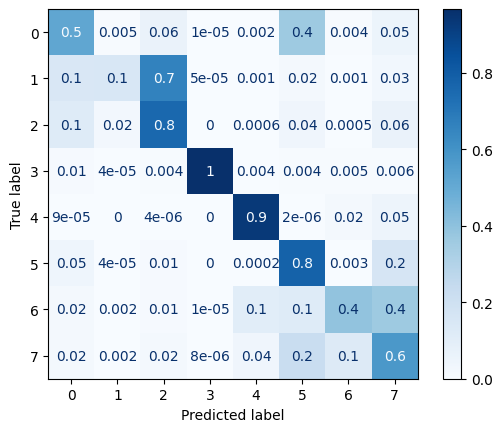

In [413]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ===== Confusion Matrix =====
gts = []
preds  = []
for data, target in test_loader:
    target = target.type(torch.LongTensor) #avoid an error idk why?
    data, target = data.to(device), target.to(device)
    output = model(data)
    output = output[0].flatten(-2).permute(1,0) #[200*200,8]
    target = target[0].flatten() #[200*200] expected for criterion argument (class per pixel)
    predictions = output.argmax(1).cpu().detach().numpy()
    ground_truth = target.cpu().detach().numpy()
    accuracy_float = (predictions == ground_truth).mean()
    gts.append(ground_truth)
    preds.append(predictions)
print(len(gts))
print(len(preds))
gts = np.array(gts).flatten()
preds = np.array(preds).flatten()

conf_matrix = confusion_matrix(gts, preds)
display = ConfusionMatrixDisplay.from_predictions(gts, preds,normalize='true',cmap="Blues",values_format='.0g')

display
LABEL_CLASSES = {
      'rocks': 		  7,
      'scree': 			    6,
      'sparse_rocks': 	  5,
      'water': 				      3,
      'glacier_and_permanent_snow': 			    4,
      'forest': 			    1,
      'sparse_forest':   2,
      'grasslands_and_others': 				    0,
      
    }

In [365]:
LABEL_CLASSES = {
      'rocks': 		  7,
      'scree': 			    6,
      'sparse_rocks': 	  5,
      'water': 				      3,
      'glacier_and_permanent_snow': 			    4,
      'forest': 			    1,
      'sparse_forest':   2,
      'grasslands_and_others': 				    0,
      
    }
    
def data_information(conf_matrix):
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.matshow(np.zeros((6,conf_matrix.shape[1])), cmap=plt.cm.Blues, alpha=1)
    for j in range(len(conf_matrix)):
        ax.text(x=j, y=0,s=np.round(np.sum(conf_matrix[j,:])/np.sum(conf_matrix),decimals=2), va='center', ha='center', size='x-large')
        ax.text(x=j, y=1,s=np.round(conf_matrix[j,j]/np.sum(conf_matrix[j,:]),decimals=2), va='center', ha='center', size='x-large')
        ax.text(x=j, y=2,s=np.round(conf_matrix[j,j]/np.sum(conf_matrix[:,j]),decimals=2), va='center', ha='center', size='x-large')
        
        
    ax.text(x=0, y=4,s=np.round(np.sum(np.diag(conf_matrix))/np.sum(conf_matrix),decimals=2), va='center', ha='center', size='x-large')
    ax.text(x=0, y=5,s=np.round(np.sum(np.diag(conf_matrix)/np.sum(conf_matrix,axis=1))/len(conf_matrix),decimals=2), va='center', ha='center', size='x-large')
    
    ax.set_yticklabels(['',"Pixel_class", "Producer_accuracy","User_accuracy", "","Overall_accuracy", "Average_accuracy"])
    ax.set_xticklabels(['',"grasslands_and_others","forest","sparse_forest","water","glacier/snow","sparse_rock","scree","rocks"])


    plt.title('data_information', fontsize=18)
    plt.show()

C:\Users\texau\AppData\Local\Temp\ipykernel_23756\3932547447.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',"Pixel_class", "Producer_accuracy","User_accuracy", "","Overall_accuracy", "Average_accuracy"])
C:\Users\texau\AppData\Local\Temp\ipykernel_23756\3932547447.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',"grasslands_and_others","forest","sparse_forest","water","glacier/snow","sparse_rock","scree","rocks"])


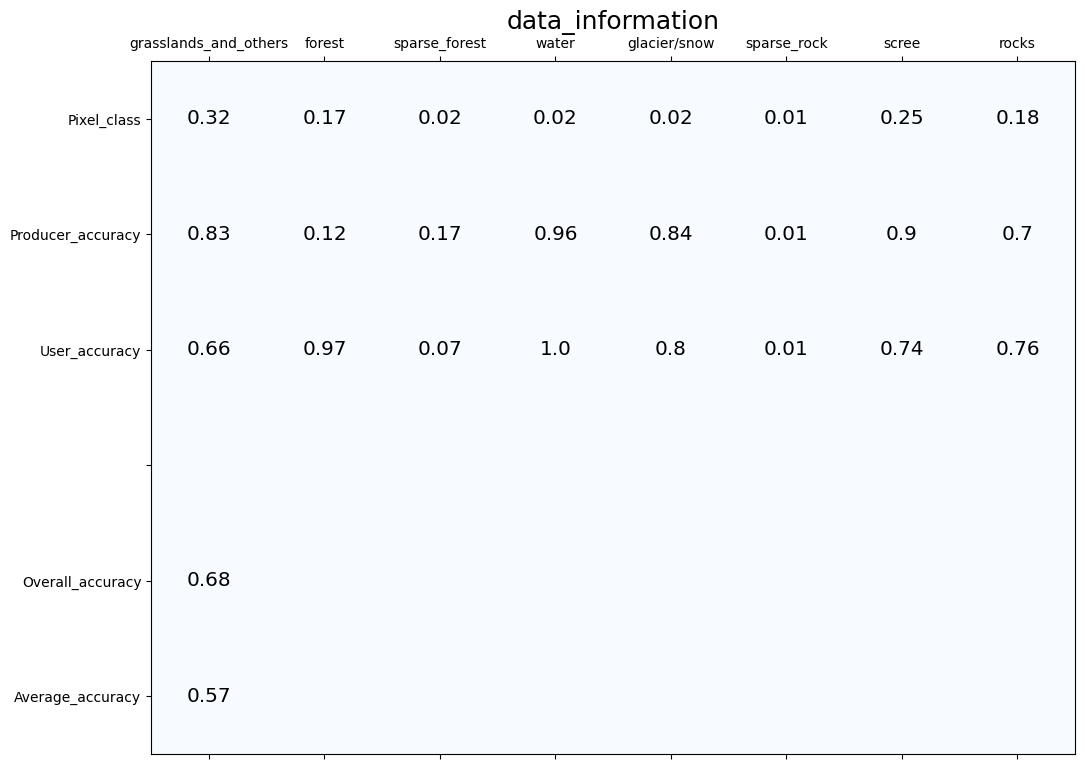

In [102]:
data_information(conf_matrix)

## Number of pixels per class in the entire training set (no need to run)
Answer in commentary

In [ ]:
print("No need to rerun!")
raise ValueError('No need to rerun!')

img, img_label = dataset[0]
img, img_label = np.array(img), np.array(img_label)

num_pix_grasslands_and_others = 0
num_pix_forest = 0
num_pix_sparse_forest = 0
num_pix_water = 0
num_pix_glacier_and_permanent_snow = 0
num_pix_sparse_rocks = 0
num_pix_scree = 0
num_pix_rocks = 0
num_pix_misclassified = 0

for i in range(len(dataset)):
    img, img_label = dataset[i]
    img, img_label = np.array(img), np.array(img_label)
    img_label = img_label.flatten()
    for j in range(img_label.shape[0]):
        if img_label[j] == 0:
            num_pix_grasslands_and_others += 1
        elif img_label[j] == 1 :
            num_pix_forest += 1
        elif img_label[j] == 2 :
            num_pix_sparse_forest += 1
        elif img_label[j] == 3 :
            num_pix_water += 1
        elif img_label[j] == 4 :
            num_pix_glacier_and_permanent_snow += 1
        elif img_label[j] == 5 :
            num_pix_sparse_rocks += 1
        elif img_label[j] == 6 :
            num_pix_scree += 1
        elif img_label[j] == 7 :
            num_pix_rocks += 1
        else:
            num_pix_misclassified += 1
            
print(f"Number of pixels of grasslands and others : {num_pix_grasslands_and_others}")
print(f"Number of pixels of forest : {num_pix_forest}")
print(f"Number of pixels of sparse forest : {num_pix_sparse_forest}")
print(f"Number of pixels of water : {num_pix_water}")
print(f"Number of pixels of glacier and permanent snow : {num_pix_glacier_and_permanent_snow}")
print(f"Number of pixels of sparse rocks : {num_pix_sparse_rocks}")
print(f"Number of pixels of scree : {num_pix_scree}")
print(f"Number of pixels of rocks : {num_pix_rocks}")
print(f"Number of pixels missclassified : {num_pix_misclassified}")

"""
ANSWER:
Number of pixels of grasslands and others : 72519725
Number of pixels of forest : 19336033
Number of pixels of sparse forest : 18342686
Number of pixels of water : 5936946
Number of pixels of glacier and permanent snow : 10797402
Number of pixels of sparse rocks : 16857098
Number of pixels of scree : 78876458
Number of pixels of rocks : 71613652
Number of pixels missclassified : 0
"""

In [ ]:
""" IF curve .. (not working)
    # ===== Plot training curves =====
    n_train = len(train_acc_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)

    plt.figure(figsize=(6.4 * 3, 4.8))
    plt.subplot(1, 3, 1)
    plt.plot(t_train, train_acc_history, label="Train")
    plt.plot(t_val, val_acc_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(1, 3, 2)
    plt.plot(t_train, train_loss_history, label="Train")
    plt.plot(t_val, val_loss_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 3, 3)
    plt.plot(t_train, lr_history)
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
"""

### Find the mean and std of the Dataset || No need run  anymore

In [ ]:

transforms_train = T.Compose([
  T.ToTensor()
])

# dataset
train_dataset = Alpine(transforms=transforms_train, split='train')
test_dataset = Alpine(transforms=transforms_train, split='test')
val_dataset = Alpine(transforms=transforms_train, split='val')

# data loader
train_loader = DataLoader(train_dataset, 
                          batch_size  = 16, 
                          shuffle     = False, 
                          num_workers = 1,
                          pin_memory  = True)
test_loader = DataLoader(test_dataset, 
                          batch_size  = 16, 
                          shuffle     = False, 
                          num_workers = 1,
                          pin_memory  = True)
val_loader = DataLoader(val_dataset, 
                          batch_size  = 16, 
                          shuffle     = False, 
                          num_workers = 1,
                          pin_memory  = True)

def mean_std():
    ####### COMPUTE MEAN / STD

    # placeholders
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    #The first two steps are done in the snippet below. Note that we set axis = [0, 2, 3] 
    #to compute mean values with respect to axis 1. The dimensions of inputs is [batch_size x 3 x image_size x image_size],
    #so we need to make sure we aggregate values per each RGB channel separately.

    # loop through images
    for img,img_label in tqdm(train_loader):
        psum    += img.sum(axis        = [0, 2, 3])
        psum_sq += (img ** 2).sum(axis = [0, 2, 3])

    for img,img_label in tqdm(test_loader):
        psum    += img.sum(axis        = [0, 2, 3])
        psum_sq += (img ** 2).sum(axis = [0, 2, 3])

    for img,img_label in tqdm(val_loader):
        psum    += img.sum(axis        = [0, 2, 3])
        psum_sq += (img ** 2).sum(axis = [0, 2, 3])

    ####### FINAL CALCULATIONS

    # image count
    s = 0
    for image in test_csv :
        s+=1
    for image in train_csv :
        s+=1
    for image in val_csv :
        s+=1
    # pixel count
    image_size = train_dataset[0][0].shape #[3,400,400]     
    count = s * image_size[1] * image_size[1]

    # mean and std
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    # output
    print('mean: '  + str(total_mean))
    print('std:  '  + str(total_std))
    return total_mean,total_std
# mean,std = mean_std()
"""
GOT: 
mean: tensor([0.4572, 0.5079, 0.4388])
std:  tensor([0.2366, 0.2141, 0.1992])
Use in normalisze transforms

"""